<a href="https://colab.research.google.com/github/SophieD517/MTL/blob/main/Exponential%20Decay/ExponentialDecay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Objectives**
1.   Can multitask learning models make reasonably accurate predictions about the features of graphs when compared to conventional artificial neural networks?
2.   When trained using a multitask learning approach, are features of graphs directly encoded within the latent space?
3.   Does the number of variables in an equation correlate with the latent dimension that yields optimal reconstruction and predictions?



In [1]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader as dl
import math as m

# https://github.com/hcarlens/pytorch-tabular/blob/master/fast_tensor_data_loader.py
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

## Generate Data
Let us begin with some toy data. We have exponential decay curves created through the first-order decay equation  

  $N(t) = N_{0}e^{\frac{t}{t_{1/2}}}$

where $t_{1/2}$ represents the time required for half of the sample to decay. Below we illustrate the distribution of half-lives used as well as the graphs drawn as a function of $t$.

Since that each curve is dependent solely on the value of $t_{1/2}$, we can draw the assumption that a compressed representation of each curve should consist of only one data point, which should correspond directly to $t_{1/2}$.

In [2]:
half_lives = [np.random.uniform(low=1, high=10)*(10**np.random.uniform(low=-2, high=3)) for i in range(10000)]
rows = []
for half_life in half_lives:
  rows.append([0.5**(t/half_life) for t in range(100)])
data = pd.DataFrame(rows)
data['half_life'] = half_lives
data

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,half_life
0,1.0,0.914374,8.360790e-01,7.644885e-01,6.990280e-01,6.391727e-01,5.844426e-01,5.343989e-01,4.886402e-01,4.467997e-01,...,2.899025e-04,2.650792e-04,2.423814e-04,2.216271e-04,2.026500e-04,1.852978e-04,1.694314e-04,1.549236e-04,1.416580e-04,7.743268
1,1.0,0.020584,4.237089e-04,8.721705e-06,1.795292e-07,3.695464e-09,7.606814e-11,1.565801e-12,3.223075e-14,6.634438e-16,...,3.400755e-154,7.000180e-156,1.440930e-157,2.966039e-159,6.105350e-161,1.256737e-162,2.586891e-164,5.324906e-166,1.096089e-167,0.178497
2,1.0,0.010977,1.204927e-04,1.322638e-06,1.451849e-08,1.593682e-10,1.749372e-12,1.920271e-14,2.107865e-16,2.313786e-18,...,4.827393e-179,5.298990e-181,5.816657e-183,6.384895e-185,7.008646e-187,7.693332e-189,8.444907e-191,9.269904e-193,1.017550e-194,0.153624
3,1.0,0.995866,9.917496e-01,9.876500e-01,9.835673e-01,9.795015e-01,9.754525e-01,9.714202e-01,9.674046e-01,9.634056e-01,...,6.859504e-01,6.831149e-01,6.802911e-01,6.774789e-01,6.746784e-01,6.718895e-01,6.691120e-01,6.663461e-01,6.635916e-01,167.333623
4,1.0,0.999022,9.980442e-01,9.970678e-01,9.960923e-01,9.951177e-01,9.941442e-01,9.931715e-01,9.921998e-01,9.912291e-01,...,9.147772e-01,9.138822e-01,9.129881e-01,9.120949e-01,9.112025e-01,9.103111e-01,9.094204e-01,9.085307e-01,9.076418e-01,708.129115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.998048,9.960989e-01,9.941541e-01,9.922131e-01,9.902758e-01,9.883424e-01,9.864127e-01,9.844867e-01,9.825646e-01,...,8.370710e-01,8.354367e-01,8.338056e-01,8.321776e-01,8.305528e-01,8.289312e-01,8.273128e-01,8.256975e-01,8.240854e-01,354.667957
9996,1.0,0.000029,8.598408e-10,2.521315e-14,7.393262e-19,2.167929e-23,6.357029e-28,1.864074e-32,5.466033e-37,1.602807e-41,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.066412
9997,1.0,0.039302,1.544644e-03,6.070754e-05,2.385925e-06,9.377154e-08,3.685405e-09,1.448437e-10,5.692640e-12,2.237319e-13,...,1.235075e-128,4.854086e-130,1.907751e-131,7.497836e-133,2.946796e-134,1.158149e-135,4.551752e-137,1.788928e-138,7.030836e-140,0.214167
9998,1.0,0.245662,6.034966e-02,1.482560e-02,3.642082e-03,8.947200e-04,2.197984e-04,5.399605e-05,1.326476e-05,3.258643e-06,...,3.316696e-56,8.147851e-57,2.001615e-57,4.917201e-58,1.207968e-58,2.967514e-59,7.290045e-60,1.790885e-60,4.399518e-61,0.493765


In [3]:
def load_data():
  test = pd.read_csv('/content/test.csv').drop(columns='Unnamed: 0')
  train = pd.read_csv('/content/train.csv').drop(columns='Unnamed: 0')
  val = pd.read_csv('/content/validate.csv').drop(columns='Unnamed: 0')
  X = torch.tensor(train.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32)
  Y = torch.tensor(train['half_life'].values, requires_grad=True, dtype=torch.float32).mul(0.001)
  X_test = torch.tensor(test.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32)
  Y_test = torch.tensor(test['half_life'].values, requires_grad=True, dtype=torch.float32).mul(0.001)
  X_val = torch.tensor(val.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32)
  Y_val = torch.tensor(val['half_life'].values, requires_grad=True, dtype=torch.float32).mul(0.001)
  return X, Y, X_test, Y_test, X_val, Y_val

[Text(0.5, 1.0, 'Half-life Distribution')]

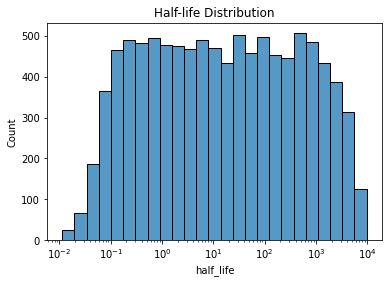

In [4]:
sns.histplot(data=data, x='half_life', bins=25, log_scale=True).set(title='Half-life Distribution')#, xlim=(10e-3, 10e2))

Text(0.5, 1.0, 'Fraction Substance Remaining Over Time')

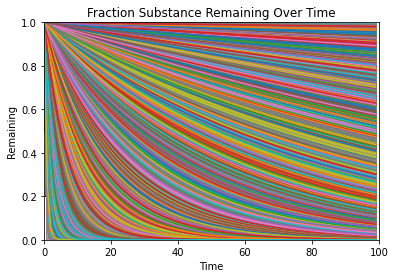

In [5]:
x = np.arange(100)
y = data.drop(columns=['half_life'])
for index, row in y.iterrows():
  plt.plot(x, row)
plt.ylabel('Remaining')
plt.xlabel('Time')
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.title('Fraction Substance Remaining Over Time')

In [6]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]
msk2 = np.random.rand(len(test)) < 0.8
validate = test[~msk2]
test = test[msk2]
train.to_csv('/content/train.csv')
test.to_csv('/content/test.csv')
validate.to_csv('/content/validate.csv')

#Neural Network

I begin with a series simple fully connected, linear layers to prove that $t_{1/2}$ is a discernible feature of the function $N(t)$. The input of the model are the curves shown above and the output is the half-life quantity.


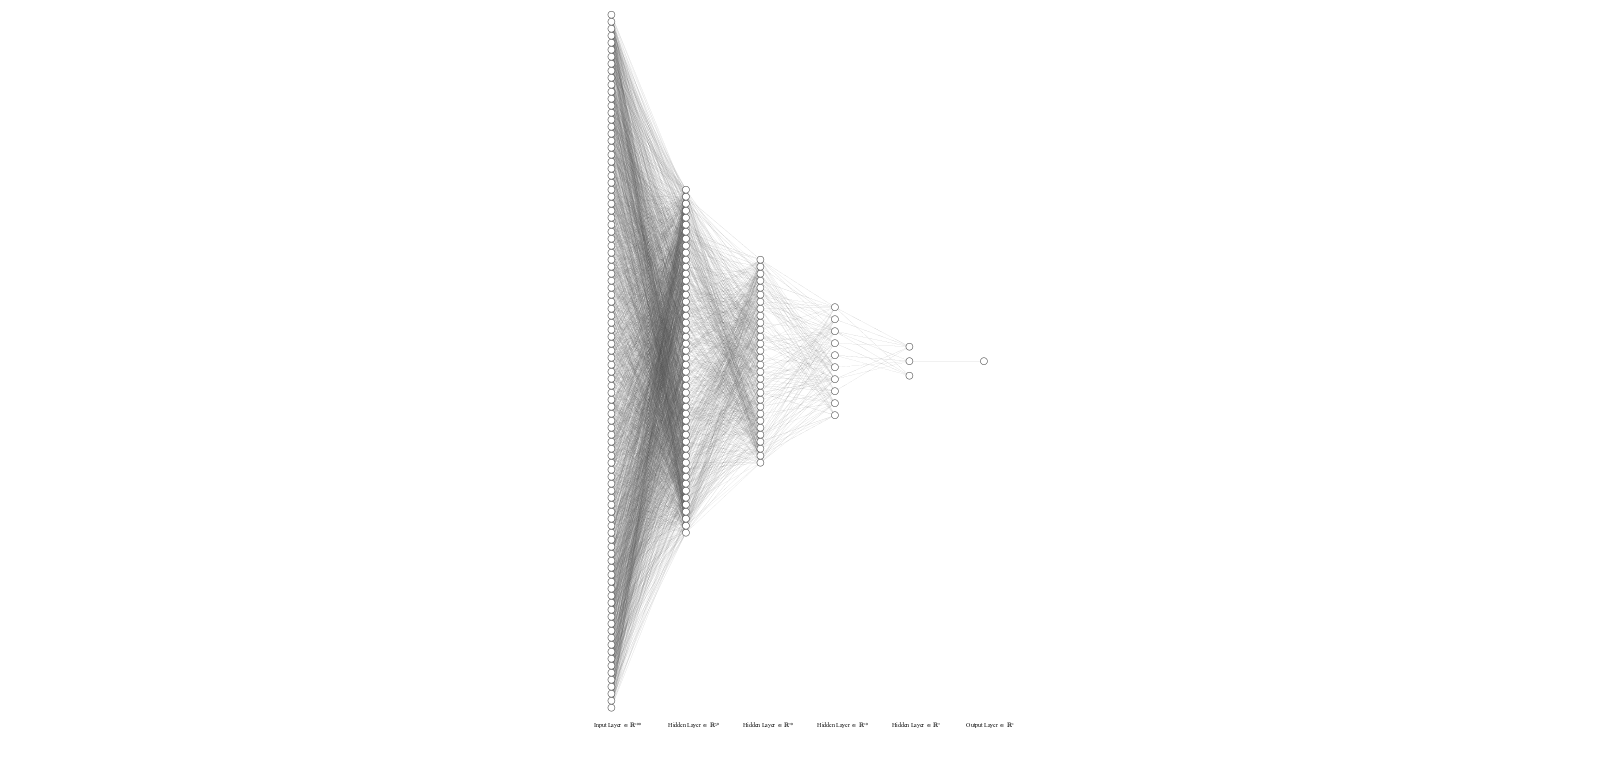

In [7]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.neural_net = torch.nn.Sequential(
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 1)
        )

    def forward(self, x):
        return self.neural_net(x)

In [26]:
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

def train(epochs, x, y, val_x, val_y):
  dataloader = FastTensorDataLoader(x, y, batch_size=128, shuffle=True)
  for epoch in range(epochs):
    for idx, data in enumerate(dataloader):
      optimizer.zero_grad()
      pred = model(data[0])
      loss = torch.nn.MSELoss()(pred.squeeze(), data[1].squeeze())
      losses.append(loss.detach().numpy())
      loss.backward(retain_graph=True)
      optimizer.step()
    print(f'loss: {loss}, val loss: {torch.nn.MSELoss()(model(val_x).squeeze(), val_y.squeeze())}')

def save():
  torch.save(model.state_dict(), 'nn.zip')

def graph_loss():
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  x = np.arange(len(losses))
  y = losses
  plt.plot(x, y, color='purple')
  plt.xlim(0)
  plt.ylim(0)

def indiv_loss(xt, yt):
  losses = []
  df = test(xt, yt)
  preds = torch.tensor(df['predicted'])
  dataloader = FastTensorDataLoader(preds, yt, batch_size=1, shuffle=False)
  for idx, row in enumerate(dataloader):
    losses.append(torch.nn.MSELoss()(row[0], row[1]).item())
  return losses

def test(x_test, y_test):
  weights = torch.load('/content/nn.zip')
  model.load_state_dict(weights)
  model.eval()
  pred = model(x_test)
  loss = torch.nn.MSELoss()(pred.squeeze(), y_test.squeeze())
  test_df = pd.DataFrame({'half_life': y_test.detach().numpy()})
  test_df['predicted'] = [item for sublist in pred.tolist() for item in sublist]
  test_df['percent_error'] = 100*(test_df['predicted'] - test_df['half_life'])/test_df['half_life']
  return test_df

def loss_hist(xt, yt):
  fig, ax = plt.subplots()
  sns.histplot(data=indiv_loss(xt, yt), ax=ax, bins=10000).set(xlim=(0, .1))
  ax.set_xlim(0)
  plt.title('loss distribution')
  plt.show()

def graph_results(xt, yt, num=1000):
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  sample_df = test(xt, yt).sample(n=num)
  y = sample_df['half_life'].apply(lambda x: x*1000)
  x = sample_df['predicted'].apply(lambda x: x*1000)
  plt.scatter(x, y, color='blue', s=.1)
  plt.plot(x, x, color='gray', linewidth=.3)
  plt.xlim(0, 1000)
  plt.ylim(0, 1000)

loss: 0.19787928462028503, val loss: 0.3473772406578064
loss: 0.003771051298826933, val loss: 0.29818078875541687
loss: 0.0671156644821167, val loss: 0.38644662499427795
loss: 0.07471100986003876, val loss: 0.2283516675233841
loss: 0.11988440155982971, val loss: 0.20133303105831146
loss: 0.1574697643518448, val loss: 0.18713904917240143
loss: 0.0017903709085658193, val loss: 0.3875981867313385
loss: 0.07039957493543625, val loss: 0.27151140570640564
loss: 0.059433385729789734, val loss: 0.21482810378074646
loss: 0.002622158033773303, val loss: 0.1565282940864563
loss: 0.08850973844528198, val loss: 0.24697372317314148
loss: 0.0777500793337822, val loss: 0.28767430782318115
loss: 0.022052332758903503, val loss: 0.580999493598938
loss: 0.26480263471603394, val loss: 0.26496177911758423
loss: 0.009616264142096043, val loss: 0.43630409240722656
loss: 0.004527848679572344, val loss: 0.3403514623641968
loss: 0.13019956648349762, val loss: 0.4185153543949127
loss: 0.14811596274375916, val los

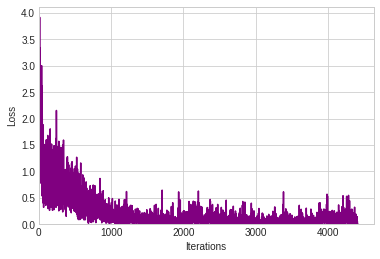

In [15]:
x, y, xt, yt, xv, yv = load_data()
train(50, x, y, xv, yv)
save()
graph_loss()

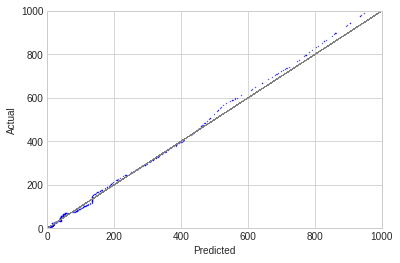

In [16]:
graph_results(xt, yt)

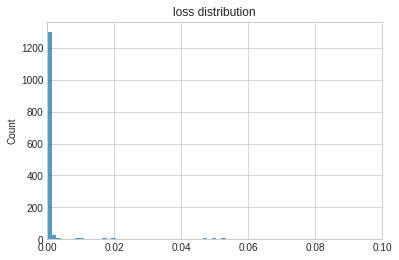

In [27]:
loss_hist(xt, yt)

# Autoencoder
Next, we attempt to perform dimensionality reduction on the dataset. Autoencoders consist of an encoder, a neural network that encodes data into the low-dimensional bottleneck layer, and a decoder, a mirror image of the encoder that reconstructs the curve from the bottleneck layer, otherwise known as the latent space. Typically, we represent this as a pair of transformations, 

$\phi:X\rightarrow F$

$\psi:F\rightarrow X'$

the composition of which is equal to 1. The goal of the autoencoder is to create a latent space, F, such that 

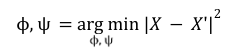

In [28]:
class AutoEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = torch.nn.Sequential(
      torch.nn.Linear(100, 70),
      torch.nn.ReLU(),
      torch.nn.Linear(70, 40),
      torch.nn.ReLU(),
      torch.nn.Linear(40, 20),
      torch.nn.ReLU(),
      torch.nn.Linear(20, 10),
      torch.nn.ReLU(),
      torch.nn.Linear(10, 2)
    )
    self.decoder = torch.nn.Sequential( 
      torch.nn.ReLU(),
      torch.nn.Linear(2, 10),
      torch.nn.ReLU(),
      torch.nn.Linear(10, 20),
      torch.nn.ReLU(),
      torch.nn.Linear(20, 40),
      torch.nn.ReLU(),
      torch.nn.Linear(40, 70),
      torch.nn.ReLU(),
      torch.nn.Linear(70, 100),
      torch.nn.Sigmoid()
    )

  def forward(self, x):
    latent_space = self.encoder(x)
    return self.decoder(latent_space)

In [47]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

def train(epochs, x, val_x):
  dataloader = FastTensorDataLoader(x, shuffle=True)
  for epoch in range(epochs):
    for idx, data in enumerate(dataloader):
      optimizer.zero_grad()
      pred = model(data[0])
      loss = torch.nn.MSELoss()(pred.squeeze(), data[0].squeeze())
      losses.append(loss.detach().numpy())
      loss.backward(retain_graph=True)
      optimizer.step()
    print(f'loss: {loss}, val loss: {torch.nn.MSELoss()(model(val_x).squeeze(), val_x.squeeze())}')

def save():
  torch.save(model.state_dict(), '/content/ae.zip') 

def graph_loss():
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  x = np.arange(len(losses))
  y = losses
  plt.plot(x, y)
  plt.xlim(0)
  plt.ylim(0)

def test(xt):
  weights = torch.load('/content/ae.zip')
  model.load_state_dict(weights)
  model.eval()
  pred = model(xt)
  loss = torch.nn.MSELoss()(pred, xt).detach().numpy()
  return loss, pred.detach().numpy()

def graph_recon(xt):
  color = []
  for i in range(2000):
      color.append('#%06X' % np.random.randint(0, 0xFFFFFF))

  loss, recon = test(xt)
  print(f'test loss: {loss}')
  plt.style.use('seaborn-whitegrid')
  figs, axs = plt.subplots(1, 2)
  figs.set_size_inches(12, 6)
  axs[0].set(xlim=(0, 100), ylim=(0, 1), title='Original', xlabel='time', ylabel='sample remaining')
  axs[1].set(xlim=(0, 100), ylim=(0, 1), title='Reconstructed', xlabel='time', ylabel='sample remaining')
  x = np.linspace(0, 100, 100, endpoint=False)
  for i in np.random.randint(0, high=1000, size=200):
    axs[0].plot(x, xt.detach().numpy()[i], color=color[i])
    axs[1].plot(x, recon[i], color=color[i])    

loss: 0.002634316449984908, val loss: 0.0023724210914224386
loss: 0.0005985360476188362, val loss: 0.0005591273074969649
loss: 0.00027485788450576365, val loss: 0.00047482061199843884
loss: 0.0003309424500912428, val loss: 0.0003558709577191621
loss: 0.00030893177608959377, val loss: 0.00034478167071938515
loss: 0.0003391608770471066, val loss: 0.0002841525711119175
loss: 0.0002613251272123307, val loss: 0.0004298979474697262
loss: 0.0002941556158475578, val loss: 0.0002327032998437062
loss: 0.00013201299589127302, val loss: 0.00017312966519966722
loss: 0.00019104169041384012, val loss: 0.00014636181003879756


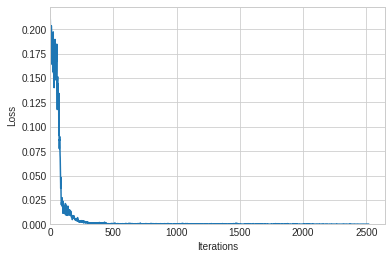

In [35]:
x, y, xt, yt, xv, yv = load_data()
train(10, x, xv)
save()
graph_loss()

test loss: 0.00013688299804925919


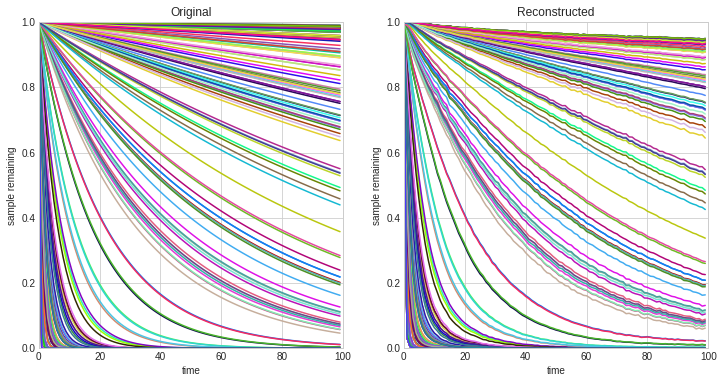

In [48]:
graph_recon(xt)

# Multitask Learning
Combining the objectives of the neural network and autoencoder, we arrive at multitask learning model involving an autoencoder and a single branch as illustrated below. The normalization of data was especially important in this stage to prevent the model from prioritizing either task. Weighting of the two losses, as shown by the variable $m$ below, can also aid the model in balancing both tasks.

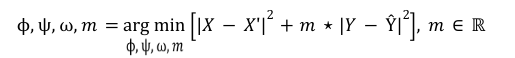

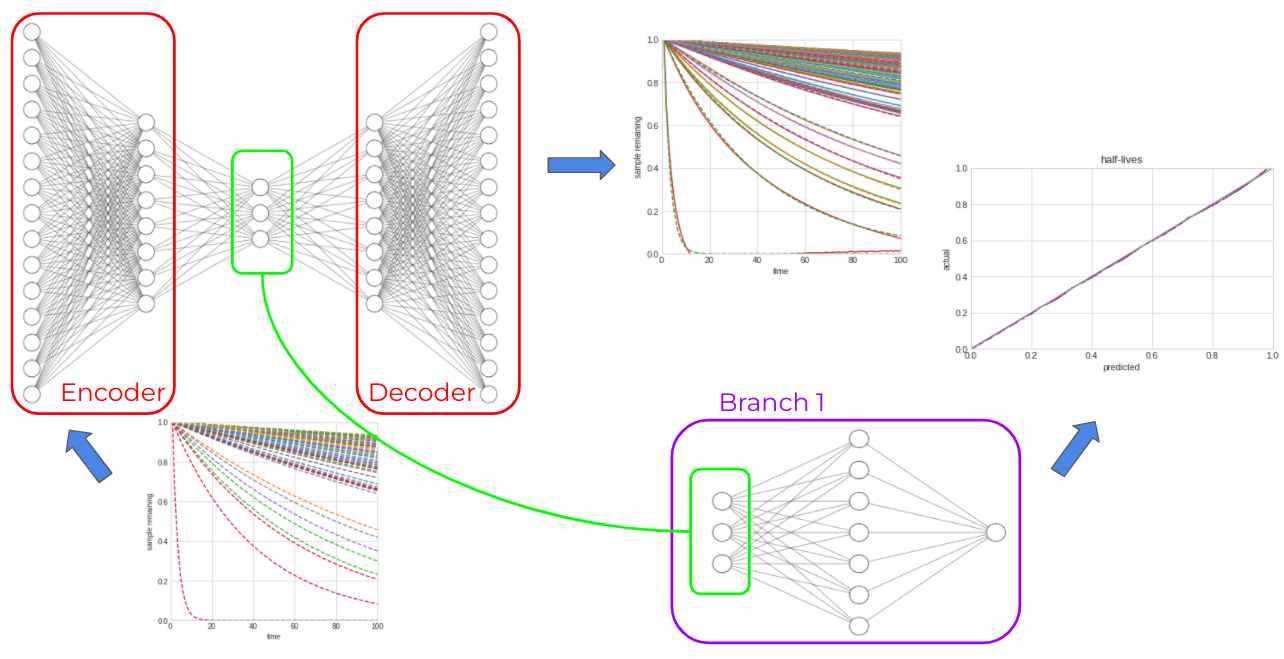

In [49]:
class Bear(torch.nn.Module):
  def __init__(self, latent_dim, ae_layer, branch1_layer):
    super().__init__()
    self.encoder = torch.nn.Sequential( 
      torch.nn.Linear(100, ae_layer),
      torch.nn.ReLU(),
      torch.nn.Linear(ae_layer, latent_dim)
    )
    self.decoder = torch.nn.Sequential( 
      torch.nn.ReLU(),
      torch.nn.Linear(latent_dim, ae_layer),
      torch.nn.ReLU(),
      torch.nn.Linear(ae_layer, 100)
    )
    self.branch1 = torch.nn.Sequential(
      torch.nn.ReLU(),
      torch.nn.Linear(latent_dim, branch1_layer),
      torch.nn.ReLU(),
      torch.nn.Linear(branch1_layer, 1)
    )

  def forward(self, x):
    latent_space = self.encoder(x)
    return latent_space, self.decoder(latent_space), self.branch1(latent_space)

In [50]:
model = Bear(3, 20, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

def train_step(x, y):
  optimizer.zero_grad()
  ls, recon, pred = model(x)
  recon_loss = torch.nn.MSELoss()(recon.squeeze(), x.squeeze())
  pred_loss = torch.nn.MSELoss()(pred.squeeze(), y.squeeze())
  loss = 2*recon_loss + pred_loss
  losses.append(loss.detach().numpy())
  loss.backward(retain_graph=True)
  optimizer.step()
  return loss

def val_step(x, y):
  ls, recon, pred = model(x)
  recon_loss = torch.nn.MSELoss()(recon.squeeze(), x.squeeze())
  pred_loss = torch.nn.MSELoss()(pred.squeeze(), y.squeeze())
  loss = 2*recon_loss.detach().numpy() + pred_loss.detach().numpy()
  return loss

def train(epochs, x, y, val_x, val_y):
  dataloader = FastTensorDataLoader(x, y, batch_size=64, shuffle=True)
  for epoch in range(epochs):
    for idx, data in enumerate(dataloader):
      loss = train_step(data[0], data[1])
    print(f'loss: {loss}, val loss: {val_step(val_x, val_y)}')

def graph_loss():
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Iterations')
  x = np.arange(0, len(losses))
  y = losses 
  plt.plot(x, y, color='blue', linewidth=0.5)
  plt.ylim(0)
  plt.xlim(0)
  plt.show()

def save():
  torch.save(model.state_dict(), 'model.zip')

def indiv_loss(xt, yt):
  losses = []
  weights = torch.load('/content/model.zip')
  model.load_state_dict(weights)
  model.eval()
  ls, recon, preds = model(xt)
  dataloader = FastTensorDataLoader(preds, yt, recon, xt, batch_size=1, shuffle=False)
  for idx, row in enumerate(dataloader):
    loss = torch.nn.MSELoss()(row[0].squeeze(), row[1].squeeze()).item() + 2*torch.nn.MSELoss()(row[2].squeeze(), row[3].squeeze()).item()
    losses.append(loss)
  return losses

def loss_hist(xt, yt):
  fig, ax = plt.subplots()
  sns.histplot(data=indiv_loss(xt, yt), ax=ax, bins=1000).set(xlim=(0, 1))
  ax.set_xlim(0)
  plt.title('loss distribution')
  plt.show()

def graph_results(xt, yt, num=1000):
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Actual')
  plt.ylabel('Predict')
  losses = []
  weights = torch.load('/content/model.zip')
  model.load_state_dict(weights)
  model.eval()
  ls, recon, preds = model(xt)
  y = [i*1000 for i in preds.detach().numpy()]
  x = [i*1000 for i in yt.detach().numpy()]
  plt.scatter(x, y, color='blue', s=.1)
  plt.plot(x, x, color='gray', linewidth=.3)
  plt.xlim(0, 1000)
  plt.ylim(0, 1000)

def graph_recon(xt):
  color = []
  for i in range(2000):
      color.append('#%06X' % np.random.randint(0, 0xFFFFFF))
  ls, recon, preds = model(xt)
  plt.style.use('seaborn-whitegrid')
  figs, axs = plt.subplots(1, 2)
  axs[0].set(xlim=(0, 100), ylim=(0, 1), title='Original', xlabel='time', ylabel='sample remaining')
  axs[1].set(xlim=(0, 100), ylim=(0, 1), title='Reconstructed', xlabel='time', ylabel='sample remaining')
  x = np.linspace(0, 100, 100, endpoint=False)
  for i in np.random.randint(0, high=1000, size=200):
    axs[0].plot(x, xt.detach().numpy()[i], color=color[i])
  for i in np.random.randint(0, high=1000, size=200):
    axs[1].plot(x, recon.detach().numpy()[i], color=color[i])

loss: 0.014048382639884949, val loss: 0.40630482509732246
loss: 0.07198192924261093, val loss: 0.2878708422649652
loss: 0.11031030118465424, val loss: 0.3716922902967781
loss: 0.005781511776149273, val loss: 0.30257606878876686
loss: 0.12239765375852585, val loss: 0.19746787648182362
loss: 0.06959249079227448, val loss: 0.18810633767861873
loss: 0.01626860536634922, val loss: 0.22229800070635974
loss: 0.3215969204902649, val loss: 0.1925303436582908
loss: 0.6635644435882568, val loss: 0.21357315848581493
loss: 0.19157862663269043, val loss: 1.0567133170552552
loss: 1.3617637157440186, val loss: 1.0310497253667563
loss: 1.4756462574005127, val loss: 1.008045595139265
loss: 0.3795834481716156, val loss: 0.9870654474943876
loss: 0.18845409154891968, val loss: 0.9574171374551952
loss: 0.10673972964286804, val loss: 0.9448650903068483
loss: 0.9428369998931885, val loss: 0.9466940062120557
loss: 0.5353451371192932, val loss: 0.8747513322159648
loss: 1.1919114589691162, val loss: 0.8334971298

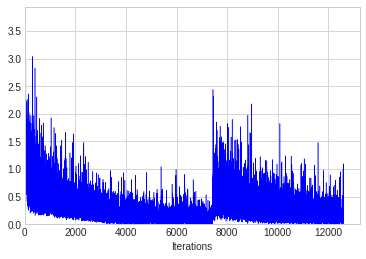

In [55]:
x, y, xt, yt, xv, yv = load_data()
train(50, x, y, xv, yv)
save()
graph_loss()

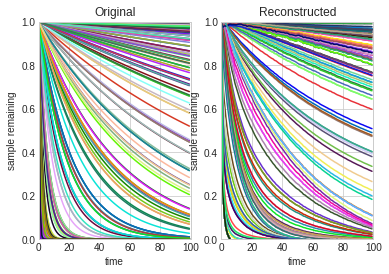

In [56]:
graph_recon(xt)

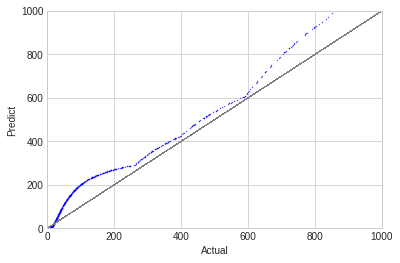

In [57]:
graph_results(xt, yt)

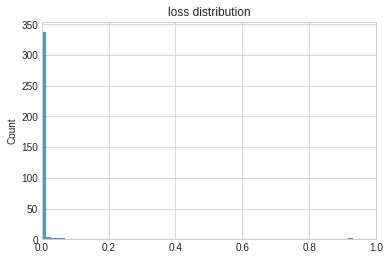

In [58]:
loss_hist(xv, yv)